In [1]:
import pandas as pd

# Load the CSV file
file_path = 'subnet_cost.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

/var/folders/xn/f45snygj4dg1140snx3x4_0m0000gp/T/ipykernel_16744/2731154127.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,year,month,day,hour,minute,second,cost
0,2024,2,18,22,54,24,567.264870026 ...
1,2024,2,18,23,54,29,561.454673858
2,2024,2,19,0,54,36,555.684002834
3,2024,2,19,1,54,41,549.873806666
4,2024,2,19,2,54,47,544.103135642


In [2]:
from datetime import datetime

# Convert the year, month, day, hour, minute, and second columns into a single datetime column
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour', 'minute', 'second']])

# Ensure the cost column is in a numeric format
data['cost'] = pd.to_numeric(data['cost'], errors='coerce')

# Sort the data by datetime just in case it's not in order
data = data.sort_values(by='datetime')

# Drop any rows with NaN values in the cost column, as they cannot be used for prediction
data = data.dropna(subset=['cost'])

In [15]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data for linear regression
# Convert datetime to a numeric format by calculating the number of seconds from the first timestamp
data['seconds_from_start'] = (data['datetime'] - data['datetime'].min()).dt.total_seconds()

# Define the independent variable (X) and the dependent variable (y)
X = data[['seconds_from_start']]
y = data['cost']

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict when the cost will drop below 300 and 200 using the model
# First, we find the seconds from the start to these costs and then convert these back to dates

def predict_date_for_cost(target_cost):
    seconds_from_start_to_target_cost = (target_cost - model.intercept_) / model.coef_[0]
    target_date = data['datetime'].min() + pd.to_timedelta(seconds_from_start_to_target_cost, unit='s')
    return target_date

date_below_363 = predict_date_for_cost(363)
date_below_300 = predict_date_for_cost(300)
date_below_200 = predict_date_for_cost(200)

print(f'Price below 363 date: {date_below_363}')
print(f'Price below 300 date: {date_below_300}')
print(f'Price below 200 date: {date_below_200}')

Price below 363 date: 2024-02-20 10:16:51.770985722
Price below 300 date: 2024-02-20 21:11:42.920691866
Price below 200 date: 2024-02-21 14:31:09.824987332


/Users/tonyle/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


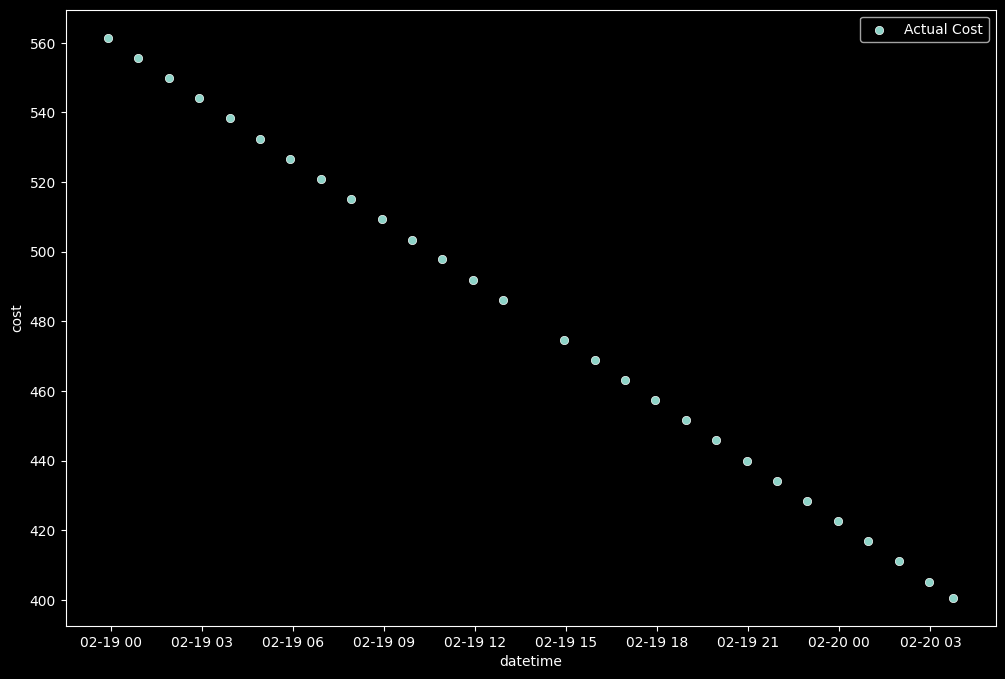

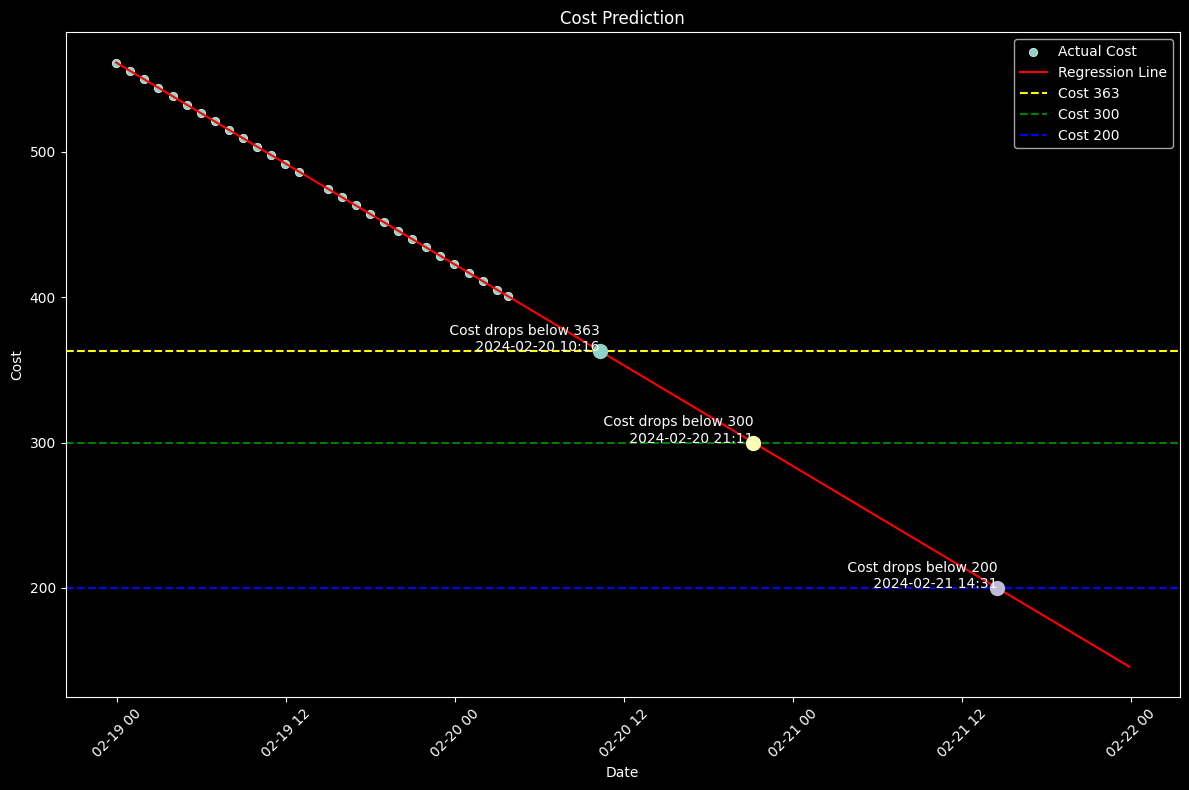

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the data along with the regression line and the points where cost drops below 300 and 200

# Create a scatter plot of the data
plt.figure(figsize=(12, 8), dpi=100)
sns.scatterplot(x='datetime', y='cost', data=data, label='Actual Cost')

# Generate dates for predictions (from start to a bit beyond our last prediction) for plotting the regression line
prediction_dates = pd.date_range(start=data['datetime'].min(), end=date_below_200 + pd.Timedelta(days=1))
prediction_seconds_from_start = (prediction_dates - data['datetime'].min()).total_seconds()
prediction_seconds_from_start = prediction_seconds_from_start.to_numpy().reshape(-1, 1)
prediction_costs = model.predict(prediction_seconds_from_start)

# Now, let's plot again with the correction
plt.figure(figsize=(12, 8))
sns.scatterplot(x='datetime', y='cost', data=data, label='Actual Cost')
sns.lineplot(x=prediction_dates, y=prediction_costs, color='red', label='Regression Line')
plt.axhline(y=363, color='yellow', linestyle='--', label='Cost 363')
plt.axhline(y=300, color='green', linestyle='--', label='Cost 300')
plt.axhline(y=200, color='blue', linestyle='--', label='Cost 200')

# Highlight the predicted dates for cost dropping below 300 and 200 and 363
for label, date, cost in [('Cost drops below 363', date_below_363, 363),
                          ('Cost drops below 300', date_below_300, 300),
                          ('Cost drops below 200', date_below_200, 200)]:
    plt.plot(date, cost, 'o', markersize=10)
    plt.text(date, cost, f' {label}\n {date.strftime("%Y-%m-%d %H:%M")}', ha='right')

plt.xlabel('Date')
plt.ylabel('Cost')
plt.title('Cost Prediction')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()
